# Background on Sample Data
In this lecture, we will be working with the data generated from CHBE473: Armfield Heat Exchanger Unit.

The purpose of this lab is to vary parameters of the setup to see its impact heat transfer. The goal of the experiment is vary parameters and determine its impact on heat transfer. Some parameters we will vary are the temperature of the hot stream and the flow rate of cold water stream.

Because our goal is to learn the data analysis, we will not look too deeply into the results and focus on how we efficiently analysis the data without considering too much on the theory of heat transfer

Key Terms:

1) Heat exchanger: a unit where a hot stream and cold stream exchange heat
2) Cocurrent:  heat exchanger configuration where the hot and cold stream travel in the same direction 
* Streams ENTER at the same side of the heat exchanger
* Streams EXIT at the same side of the heat exchanger

Experimental Setup:
1) A hot water stream at temperature we set enters the heat exchanger
2) A cold stream (city water ~20-21 C) enters the heat exchanger
3) The flow rate of the cold stream is varied throughout the experiment
4) The flow rate of the hot stream is fixed at a constant value (~2 L/min)

The experimental heat transfer coefficient ($U_{exp}$) is calculated using
$$Q = U_{exp} * A * LMTD $$
where
$$A = N_{tubes} * \pi * Diameter * Length $$
$$A = 7 * \pi * 0.00515 (meters) * 0.144 (meters) $$

We can find Q based on the temperature change of the hot water stream 
$$Q = m_{water} * C_p * (T_{in} - T_{out}) $$
$$Q = m_{hot water} * C_p * (T_2 - T_1) $$

We can find the mass flow rate of each stream by converting volume flow rate to mass flow rates
$$m_{water} = V_{water}\frac{L}{min} * \frac{1 m^3}{1000 L} * \frac{977 kg}{m^3} * \frac{1 min}{60 sec} $$
<br>

For a cocurrent heat exchanger, the LMTD is represented by
$$LMTD = \frac{(T_{hot,out} - T_{cold,out}) - (T_{hot,in} - T_{cold,in})}{ln(\frac{T_{hot,out} - T_{cold,out}}{T_{hot,in} - T_{cold,in}})} $$

The data represents the cold and hot streams using T1, T2, T3, T4. Based on a cocurrent configuration we can translate LMTD to
$$LMTD = \frac{(T_1 - T_4) - (T_2 - T_3)}{ln(\frac{T_1 - T_4}{T_2 - T_3})} $$

We can make further simplifications to make it easier to code the analysis
$$ \Delta T_1 = T1 - T4 $$
$$ \Delta T_2 = T2 - T3 $$
$$LMTD = \frac{\Delta T_1 - \Delta T_2}{ln(\frac{\Delta T_1}{\Delta T_2})} $$

<img src="../jupyter-notebook-images/heat-exchanger-diagram.jpg" width="750"/>

# Main Goals and Learning Outcomes
## Checklist:

    1) Import data from one excel file with multiple worksheets
    2) Cleaning up data before processing/analysis
    3) Data analysis based on chemical engineering
    2) Plotting with special greek labels and error bars

## Import Modules

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Import Data

In [46]:
# Main data file
co_current_data = pd.read_excel("../Sample-Data/Heat-Exchanger-Example/Fri3 Day 2 Data - Cocurrent.xlsx", sheet_name = None)

# Read the append data files (additional data)
co_current_data["100% CWF, 65C HW"] = pd.read_excel("../Sample-Data/Heat-Exchanger-Example/Fri3 Day 2 Data - Cocurrent - Append.xlsx")

### Remove sheets with bad data

In [47]:
# Remove the bad runs
del co_current_data['Run 21']
del co_current_data['Run 23']

## Pre-Analysis Data Clean Up

### A) Dictate which columns we want to extract from the excels and their alternative name/label

In [48]:
columns_dict = {"Temp \nT1 \n \n[°C]":"T1",
                "Temp \nT2 \n \n[°C]":"T2",
                "Temp \nT3 \n \n[°C]":"T3",
                "Temp \nT4 \n \n[°C]":"T4",
                "Hot Water \nFlowrate \nFhot \n[l/min]":"HW_Rate_L_min",
                "Cold Water \nFlowrate \nFcold \n[l/min]":"CW_Rate_L_min",
                }

### B) Grab only the first 30 data points from each file
* ensures same number of data points for each run

In [49]:
summary_dict_mean = {}
summary_dict_std = {}

for (run_name, data) in co_current_data.items():
    reduced_data = data.loc[:30,list(columns_dict.keys())]
    summary_dict_mean[run_name] =  reduced_data.mean()
    summary_dict_std[run_name] =  reduced_data.std()

### C) Rename the columns so they are easier to read and work with

In [50]:
summary_mean = pd.DataFrame(summary_dict_mean).T.rename(columns=columns_dict).reset_index().round(3)
summary_std = pd.DataFrame(summary_dict_std).T.rename(columns=columns_dict).reset_index().round(3)

### D) Label the experiments based on the file name
* Constant columns represents the variable that was keep constant during the experiment

In [51]:
summary_mean["Constant"] = summary_mean["index"].apply(lambda x: x.split()[-1])
summary_std["Constant"] = summary_std["index"].apply(lambda x: x.split()[-1])

## Data Aggregation

In [52]:
A_T = 7*np.pi*0.00515*0.144
Cp = 4184 # 4182 J/kg C

summary_mean["m_hot (kg/s)"] = summary_mean["HW_Rate_L_min"]/1000/60 * 977

summary_mean["Q_T Hot (J/s)"] = summary_mean["m_hot (kg/s)"] * Cp * (abs(summary_mean["T1"] - summary_mean["T2"]))

summary_mean["\u0394T_1"] = summary_mean.T1 - summary_mean.T4
summary_mean["\u0394T_2"] = summary_mean.T2 - summary_mean.T3
summary_mean["\u0394T_LM"] = (summary_mean["\u0394T_2"] - summary_mean["\u0394T_1"]) / np.log(summary_mean["\u0394T_2"]/summary_mean["\u0394T_1"])

summary_mean["U_exp"] = summary_mean["Q_T Hot (J/s)"] / (A_T * summary_mean["\u0394T_LM"]) # U = QT / (A_T * T_LM)

# summary_mean.iloc[-1,-1] = 1711.8038

In [53]:
summary_mean

,index,T1,T2,T3,T4,HW_Rate_L_min,CW_Rate_L_min,Constant,m_hot (kg/s),Q_T Hot (J/s),ΔT_1,ΔT_2,ΔT_LM,U_exp
0,"40C HW, 60% CWF",37.188,39.941,21.319,23.241,1.985,3.571,CWF,0.032322,372.307437,13.947,18.622,16.172036,1411.625113
1,"42.5C HW, 60% CWF",39.389,42.435,22.197,24.298,1.998,3.554,CWF,0.032534,414.629666,15.091,20.238,17.538809,1449.581513
2,"45C HW, 60% CWF",41.573,45.035,22.448,24.829,1.991,3.530,CWF,0.032420,469.605649,16.744,22.587,19.519966,1475.151473
3,"47.5C HW, 60% CWF",43.679,47.586,22.498,25.157,1.996,3.527,CWF,0.032502,531.298925,18.522,25.088,21.639227,1505.495830
4,"50C HW, 60% CWF",45.556,49.873,22.041,25.004,1.999,3.561,CWF,0.032550,587.935700,20.552,27.832,24.008323,1501.586570
5,"52.5C HW, 60% CWF",47.741,52.742,21.077,24.480,1.996,3.527,CWF,0.032502,680.068064,23.261,31.665,27.247335,1530.420280
6,"55C HW, 60% CWF",49.554,54.952,21.144,24.801,1.990,3.533,CWF,0.032404,731.848094,24.753,33.808,29.045638,1544.978315
7,"57.5C HW, 60% CWF",51.645,57.551,21.223,25.068,2.002,3.688,CWF,0.032599,805.550006,26.577,36.328,31.198946,1583.196986
8,"60C HW, 60% CWF",53.630,59.946,21.269,25.405,2.016,3.722,CWF,0.032827,867.496314,28.225,38.677,33.177056,1603.290296
9,"62.5C HW, 60% CWF",55.710,62.580,21.300,25.715,2.010,3.711,CWF,0.032729,940.779366,29.995,41.280,35.337690,1632.420343


In [54]:
A_T = 7*np.pi*0.00515*0.144

Cp = 4182 # 4182 J/kg C

summary_std["m_hot (kg/s)"] = summary_std["HW_Rate_L_min"]/1000/60 * 977
summary_std["Q_T Hot (J/s)"] = ((summary_std["T1"])**2 + (summary_std["T2"])**2)**0.5 * Cp

summary_std["\u0394T_1"] = ((summary_std.T1)**2 + (summary_std.T3)**2)**0.5
summary_std["\u0394T_2"] = ((summary_std.T2)**2 + (summary_std.T4)**2)**0.5
summary_std["\u0394T_LM"] = ((summary_std["\u0394T_1"])**2 + (summary_std["\u0394T_2"])**2)**0.5 

summary_std["U_exp"] = ((summary_std["Q_T Hot (J/s)"])**2 + (summary_std["\u0394T_LM"])**2)**0.5 * A_T


In [55]:
summary_std.head()

,index,T1,T2,T3,T4,HW_Rate_L_min,CW_Rate_L_min,Constant,m_hot (kg/s),Q_T Hot (J/s),ΔT_1,ΔT_2,ΔT_LM,U_exp
0,"40C HW, 60% CWF",0.099,0.104,0.071,0.068,0.080,0.086,CWF,0.001303,600.477535,0.121828,0.124258,0.174017,9.792970
1,"42.5C HW, 60% CWF",0.174,0.159,0.062,0.046,0.072,0.105,CWF,0.001172,985.719667,0.184716,0.165520,0.248026,16.075744
2,"45C HW, 60% CWF",0.175,0.168,0.027,0.025,0.081,0.071,CWF,0.001319,1014.503553,0.177071,0.169850,0.245363,16.545169
3,"47.5C HW, 60% CWF",0.203,0.231,0.014,0.036,0.077,0.077,CWF,0.001254,1286.058497,0.203482,0.233788,0.309939,20.973860
4,"50C HW, 60% CWF",0.176,0.276,0.141,0.133,0.064,0.082,CWF,0.001042,1368.939230,0.225515,0.306374,0.380423,22.325532


## Plot Experimental Heat Transfer Coefficent vs Cold Water Flow Rate

Text(0.5, 1.0, '$U_{exp}$ vs Cold Water Flow Rate')

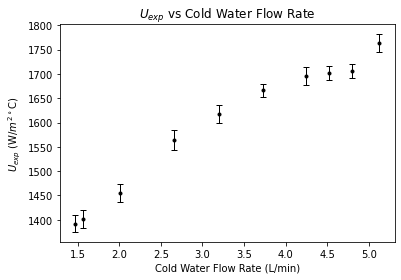

In [56]:
mean = summary_mean[summary_mean.Constant == "HW"]
std = summary_std[summary_std.Constant == "HW"]

plt.errorbar(mean.CW_Rate_L_min, mean.U_exp, yerr=std.U_exp, fmt='.k', capsize=3, elinewidth=1)
plt.ylabel("$U_{exp}$ (W/$m^2$$^\circ$C)")
plt.xlabel("Cold Water Flow Rate (L/min)")
plt.title('$U_{exp}$ vs Cold Water Flow Rate')

## Plot Experimental Heat Transfer Coefficent vs Hot Water Temperature

Text(0.5, 1.0, '$U_{exp}$ vs Inlet Hot Water Temp')

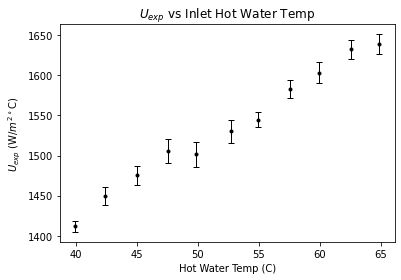

In [57]:
mean = summary_mean[summary_mean.Constant == "CWF"]
std = summary_std[summary_std.Constant == "CWF"]

plt.errorbar(mean.T2, mean.U_exp, yerr=std.U_exp*0.7, fmt='.k', capsize=3, elinewidth=1)
plt.ylabel("$U_{exp}$ (W/$m^2$$^\circ$C)")
plt.xlabel("Hot Water Temp (C)")
plt.title('$U_{exp}$ vs Inlet Hot Water Temp')

# Plotting both on one plot

Text(0.5, 1.0, '$U_{exp}$ vs Inlet Hot Water Temp')

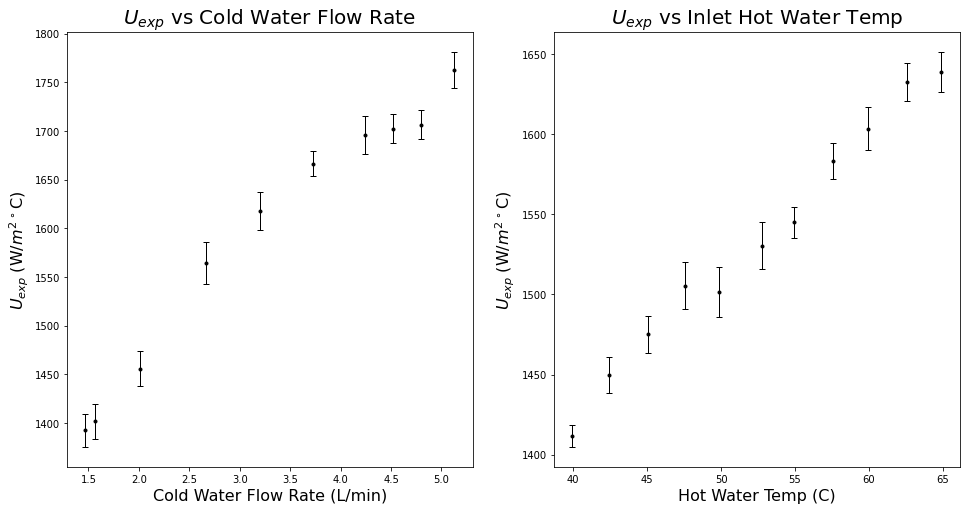

In [58]:
# Set figure size
plt.figure(figsize=(16,8))

# Plot data for experiment keeping hot water temp constant
mean = summary_mean[summary_mean.Constant == "HW"]
std = summary_std[summary_std.Constant == "HW"]

plt.subplot(1,2,1)
plt.errorbar(mean.CW_Rate_L_min, mean.U_exp, yerr=std.U_exp, fmt='.k', capsize=3, elinewidth=1)
plt.ylabel("$U_{exp}$ (W/$m^2$$^\circ$C)", fontsize=16)
plt.xlabel("Cold Water Flow Rate (L/min)", fontsize=16)
plt.title('$U_{exp}$ vs Cold Water Flow Rate', fontsize=20)

# Plot data for experiment keeping cold water flow rate constant
plt.subplot(1,2,2)
mean = summary_mean[summary_mean.Constant == "CWF"]
std = summary_std[summary_std.Constant == "CWF"]

plt.errorbar(mean.T2, mean.U_exp, yerr=std.U_exp*0.7, fmt='.k', capsize=3, elinewidth=1)
plt.ylabel("$U_{exp}$ (W/$m^2$$^\circ$C)", fontsize=16)
plt.xlabel("Hot Water Temp (C)", fontsize=16)
plt.title('$U_{exp}$ vs Inlet Hot Water Temp', fontsize=20)